***
# Exploratory Data Analysis
MSDS 7331-403, Lab 1  
*Jenna Ford, Edward Fry, Christian Nava, and Jonathan Tan* 
***

## Python Preparation and Dataset Loading

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from plotly.offline import iplot_mpl

# Preprocessing for dealing with categorical variables
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Geospacial plotting
import geopandas as gpd
import json
from bokeh.io import curdoc, output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Slider, HoverTool
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column

# File system management
import os.path

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [3]:
# Constants
DATA_SOURCE = '../Data/Arrest_Data_from_2010_to_Present.csv'

# Options
pd.set_option('float_format', '{:.2f}'.format)  # Reign in the scientific notation for reasonable values

# Load data for analysis; only read if needed because the import can take a long time
try:
    if len(df.index) < 1:
        df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe was empty
except:   
    df_raw = pd.read_csv(DATA_SOURCE) # If we get here, the dataframe did not exist

In [4]:
# make copy of dataset
df = df_raw
print("The data set has {:,} rows and {:,} columns".format(*df.shape))

The data set has 1,324,973 rows and 17 columns


## Business Understanding
*(10 points)*

*Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Describe how you would define and measure the outcomes from the dataset. That is, why is this data important and how do you know if you have mined useful knowledge from the dataset? How would you measure the effectiveness of a good prediction algorithm? Be specific.*

Our group has chosen to use a dataset comprising of Los Angeles arrest incidents dating back to 2010. We obtained the data from the [City of Los Angeles open data](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4). This datset contains information about the date, time and location of the incident, demographic data of the person arrested, and information about the type of incident.

While the purpose of the dataset was not specified in the information available to us, we have chosen to classify the type of arrest (Felony, Misdemeanor, etc). We feel that being able to classify arrest type could help in prioritizing dispatch calls, especially when there are more calls than officers available to respond. We assume that arrest type is an indicator of the severity of the incident. It is also worth noting that most of the data available for the classification would be available to the dispatcher. For example, someone placing a call to 911 would most likely have a basic description of the offender such as gender, approximate age and ethnicity. The caller would also know the location of the incident. 

We will measure effectiveness of our classification model by looking at accuracy. Arrest type has 4 distinct values, indicating a 25% chance of picking the correct arrest type at random. A successful model ideally would exceed the ability of a dispatcher to correctly identify the arrest type. Since we do not have data available for this, we will use 25% as the cut-off for identifying if the model is successful.

## Data Understanding

### Data Meaning Type
*(10 points)*  
*Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file.*


The arrest dataset consists of 17 attributes. Attribute descriptions are provided by the [City of Los Angeles open data](https://data.lacity.org/A-Safe-City/Arrest-Data-from-2010-to-Present/yru6-6re4) and [Kaggle](https://www.kaggle.com/cityofLA/los-angeles-crime-arrest-data). Descriptions are displayed in Table 1 below:

**Table 1: Arrest Dataset - Attribute Descriptions**

| Attribute | Description |
| :--- | :--- |
| **Report ID** | Unique ID for the arrest |
| **Arrest Date** | Date in MM/DD/YYYY format |
| **Time** | In 24-hour military time |
| **Area ID** | The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21. (Also called Precincts). |
| **Area Name** | The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles. |
| **Reporting District** | A four-digit code that represents a sub-area within a Geographic Area. All arrest records reference the "RD" that it occurred in for statistical comparisons. |
| **Age** | Two character numeric.|
| **Sex Code** | F - Female; M - Male|
| **Descent Code** | Descent Code: A - Other Asian; B - Black; C - Chinese; D - Cambodian; F - Filipino; G - Guamanian; H - Hispanic/Latin/Mexican; I - American Indian/Alaskan Native; J - Japanese; K - Korean; L - Laotian; O - Other; P - Pacific Islander S - Samoan; U - Hawaiian; V - Vietnamese; W - White; X - Unknown; Z - Asian Indian |
| **Charge Group Code** | Category of arrest charge. |
| **Charge Group Description** | Defines the Charge Group Code provided. |
| **Arrest Type Code** | A code to indicate the type of charge the individual was arrested for. D - Dependent; F - Felony; I - Infraction; M - Misdemeanor; O - Other |
| **Charge** | The charge the individual was arrested for. |
| **Charge Description** | Defines the Charge provided. |
| **Address** | Street address of crime incident rounded to the nearest hundred block to maintain anonymity. |
| **Cross Street** | Cross Street of rounded Address. |
| **Location** | The location where the crime incident occurred. Actual address is omitted for confidentiality. XY coordinates reflect the nearest 100 block. |



As part of our analysis we also use geospatial files for reporting districts. These files are provided by [LA City GeoHub](http://geohub.lacity.org/datasets/4398360b1a0242b78904f46b3786ae73_0). Several fields are available in these files, in addition to geometry. We join the datasets together using Reporting District as the key.

**Table 2: Geospatial Datasets - Attribute Descriptions**

| Attribute | Description |
| :--- | :--- |
| **BUREAU** | LAPD Bureau (collection of Precincts). |
| **PREC** | 2-digit Precinct code (collection of Reporting Districts). |
| **REPDIST** | 4-digit Reporting Ristrict code. |

### Data Quality
*(15 points)*  
*Verify data quality: Explain any missing values, duplicate data, and outliers. Are those mistakes? How do you deal with these problems? Be specific.*

Quality of the data is of concern for the arrest incident data because this data is transcribed from arrest reports. The source notes that there there are also fields with missing values. 

The table below quickly highlights a formatting issue with `Time`, missing data issues with `Charge Group Description`, `Charge Description` and `Cross Street`, and an issue with `Age` (value of 2 seen in first 5 rows). A detailed analysis of duplicate data, missing data and outliers follows. We also note how we handle issues that we find.


In [5]:
df.head()

,Report ID,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location
0,191811472,05/03/2019,1700.00,18,Southeast,1802,23,F,B,nan,NaN,M,653.22 PC,NaN,91ST,FIGUEROA,"(33.9543, -118.2827)"
1,5614161,04/29/2019,1040.00,8,West LA,842,41,M,H,3.00,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,NaN,"(34.0508, -118.4592)"
2,5806609,11/23/2019,1830.00,4,Hollenbeck,457,23,F,H,3.00,Robbery,F,211PC,ROBBERY,FICKETT,CINCINNATI,"(34.0477, -118.2047)"
3,5615197,04/30/2019,615.00,6,Hollywood,663,27,M,O,5.00,Burglary,F,459PC,BURGLARY,LA BREA,LEXINGTON,"(34.0907, -118.3384)"
4,5615701,04/30/2019,1100.00,9,Van Nuys,901,2,F,H,nan,NaN,D,300(B)WIC,NaN,RAYMER,SEPULVEDA BL,"(34.2149, -118.4674)"


The information provided below shows the data type for each attribute, in addition to indicating if there are missing values. `Time` needs to be stored as a time value, instead of float64. `Area ID` and `Reporting District`, while comprised of numerical digits, are categorical variables and need to be stored as objects.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324973 entries, 0 to 1324972
Data columns (total 17 columns):
Report ID                   1324973 non-null int64
Arrest Date                 1324973 non-null object
Time                        1324777 non-null float64
Area ID                     1324973 non-null int64
Area Name                   1324973 non-null object
Reporting District          1324973 non-null int64
Age                         1324973 non-null int64
Sex Code                    1324973 non-null object
Descent Code                1324973 non-null object
Charge Group Code           1235472 non-null float64
Charge Group Description    1234943 non-null object
Arrest Type Code            1324973 non-null object
Charge                      1324973 non-null object
Charge Description          1235581 non-null object
Address                     1324973 non-null object
Cross Street                754763 non-null object
Location                    1324973 non-null object
dtypes

#### Duplicate Data

We want to make sure we have unique observations, i.e., no two records have the same values for all attributes. This will reduce the risk of biased estimates. In this dataset a duplicate record would lead to further inspection as it is unlikely two arrests were made in the exact same location, on the same date and time, for the same charge, for two individuals of the same age, gender, and ethnic descent. A check for duplicate records verifies our dataset contains unique obervations.  

In [7]:
# check for duplicate records
df.duplicated().sum()

0

#### Missing Values and Data Cleanup

The table below shows how many observations have missing values and the percentage of values that are missing, by column.

In [8]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])

In [9]:
missing_data(df)

,Total,Percent
Cross Street,570210,43.04
Charge Group Description,90030,6.79
Charge Group Code,89501,6.75
Charge Description,89392,6.75
Time,196,0.01
Location,0,0.00
Reporting District,0,0.00
Arrest Date,0,0.00
Area ID,0,0.00
Area Name,0,0.00


##### Missing Values and Data Cleanup: Cross Street

43% of observations have missing data for the `Cross Street` attribute. Due to the other location based data available (`Area ID` and `Reporting District`) and the percentage of missing values for `Cross Street`, we have decided to not use `Cross Street` and `Address` in our model.

##### Missing Values and Data Cleanup: Time

196 observations are missing `Time`. The statistics provided below highlight another issue: the presence of 24:00. 24:00 is an issue because the 24 clock goes to 23:59 and then starts over at 0:00. The source notes that 0:00 may be filled in for missing data, so any records with 0:00 for `Time` are suspect. 

In [10]:
df.Time.describe().apply(lambda x: '%.1f' % x) # suppresses scientific notation and formats to 1 decimal place

count    1324777.0
mean        1386.9
std          662.9
min            0.0
25%          945.0
50%         1510.0
75%         1930.0
max         2400.0
Name: Time, dtype: object

Upon further inspection, we found there were three observations where the time is 0.0 and 102 where the time is 24.0.

In [11]:
# select rows where Time = 0
df.loc[df['Time']== 0].shape

(3, 17)

In [12]:
# select rows where Time = 24
df.loc[df['Time']== 24].shape

(102, 17)

We will treat 0.0 and missing values as missing. Due to the large number of records in the dataset we have chosen to filter these out of the data instead of inputing them to another value. We input 24:00 to 0:00 due to the reasonable assumption that these values are equal.

In [13]:
#filter out 0 and missing
df = df[df['Time'] != 0]
df['Time'] = df['Time'].astype(str) 
df = df[df['Time'] != 'nan']

# Convert float to string. Get rid of decimals. Replace missing or invalid values with '0000'.
df['Time'] = df['Time'].astype(str).str.split(".", expand = True)[0].replace(to_replace = ['2400','nan'], value = '0000') 

# Fill time column with leading zeros to have 4 characters total
df['Time'] = df['Time'].apply(lambda x: '{0:0>4}'.format(x))

# Add colon to Time values by converting attribute to a datetime variable 
df['Time'] = pd.to_datetime(df['Time'], format = '%H%M').dt.time

#Get hour
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour


print("The data set has {:,} rows and {:,} columns after filtering on Time.".format(*df.shape))

The data set has 1,324,774 rows and 18 columns after filtering on Time.


#### Additional Attributes

We would like to investigate whether day of the week, month and year have an impact on arrests. Below we create individual columns for easier analysis. 

In [14]:
# Convert Arrest Date to datetime
df['Arrest Date'] = pd.to_datetime(df['Arrest Date'])

# Extract year, month, and day of week and add to dataframe as new attributes
df['arrest_year']= df['Arrest Date'].dt.year
df['arrest_month']= df['Arrest Date'].dt.month
df['arrest_day_of_week'] = df['Arrest Date'].dt.weekday_name

#### Remove Unecessary Attributes

`Report ID` is a unique identifier for each arrest incident. As such, this attribute is not useful for our analysis and will be removed.

For now we leave in groups of columns such as `Charge Group Description` and `Charge Group Code`. These groups of columns provide the same information and will not both be included in modeling. The description columns are useful while exploring the data.

In [15]:
# remove Report ID column
df.drop(['Report ID'], axis=1, inplace=True)

#### Correcting Data Types

The data types displayed earlier still need some adjusting. `Age` needs to be an integer and `Reporting ID`, `Area ID` and `Charge Group Code` need to be categorical.

In [16]:
# Change data types
df['Age'] = df['Age'].astype(np.int8)
df['Reporting District'] = df['Reporting District'].astype(np.str)
df['Area ID'] = df['Area ID'].astype(np.str)
df['Charge Group Code'] = df['Charge Group Code'].astype(np.str)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324774 entries, 0 to 1324972
Data columns (total 20 columns):
Arrest Date                 1324774 non-null datetime64[ns]
Time                        1324774 non-null object
Area ID                     1324774 non-null object
Area Name                   1324774 non-null object
Reporting District          1324774 non-null object
Age                         1324774 non-null int8
Sex Code                    1324774 non-null object
Descent Code                1324774 non-null object
Charge Group Code           1324774 non-null object
Charge Group Description    1234800 non-null object
Arrest Type Code            1324774 non-null object
Charge                      1324774 non-null object
Charge Description          1235438 non-null object
Address                     1324774 non-null object
Cross Street                754619 non-null object
Location                    1324774 non-null object
Hour                        1324774 non-null int64

#### Clean Dataset

The table below shows the first 5 observations in the clean dataset. Note that for now we have not discussed reasonable ages found in the dataset. This will be addressed in the Explore Joint Attrubtes Section because we found interesting interactions we want to duscuss.

In [18]:
df.head()

,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,Charge Group Code,Charge Group Description,Arrest Type Code,Charge,Charge Description,Address,Cross Street,Location,Hour,arrest_year,arrest_month,arrest_day_of_week
0,2019-05-03,17:00:00,18,Southeast,1802,23,F,B,nan,NaN,M,653.22 PC,NaN,91ST,FIGUEROA,"(33.9543, -118.2827)",17,2019,5,Friday
1,2019-04-29,10:40:00,8,West LA,842,41,M,H,3.0,Robbery,F,211PC,ROBBERY,11600 WILSHIRE BL,NaN,"(34.0508, -118.4592)",10,2019,4,Monday
2,2019-11-23,18:30:00,4,Hollenbeck,457,23,F,H,3.0,Robbery,F,211PC,ROBBERY,FICKETT,CINCINNATI,"(34.0477, -118.2047)",18,2019,11,Saturday
3,2019-04-30,06:15:00,6,Hollywood,663,27,M,O,5.0,Burglary,F,459PC,BURGLARY,LA BREA,LEXINGTON,"(34.0907, -118.3384)",6,2019,4,Tuesday
4,2019-04-30,11:00:00,9,Van Nuys,901,2,F,H,nan,NaN,D,300(B)WIC,NaN,RAYMER,SEPULVEDA BL,"(34.2149, -118.4674)",11,2019,4,Tuesday


### Simple Statistics
*(10 points)*   
*Give simple, appropriate statistics (range, mode, mean, median, variance,
counts, etc.) for the most important attributes and describe what they mean or if you found something interesting. Note: You can also use data from other sources for comparison. Explain the significance of the statistics run and why they are meaningful.*  

Simple statistics for several categorical variables are found below. We did not include both description and code columns (when both are available) or location columns. From this table we can see the following:
* There are 21 unique Areas, with Central having the most arrests. 
* There are 1351 unique Reporting Districts and Reporting District 1412 has the most arrests. 
* Men have more arrests than women. 
* Hispanics have the highest number of arrests.
* The most common arrest type is a Misdemeanor.
* The most common charge is Drunk Driving Alcohol/Drugs.
* The most common Charge Group is Miscellaneous Other Violations.

In [19]:
# Assign, clean up, and split out the classes of data
ordinalFeatures = ['Arrest Date', 'Time', 'Age','Hour']
categoricalFeatures = ['Area Name', 'Reporting District', 'Sex Code', 'Descent Code',
                       'Charge Group Description', 'Arrest Type Code', 'Charge Description']

df[categoricalFeatures].describe()

,Area Name,Reporting District,Sex Code,Descent Code,Charge Group Description,Arrest Type Code,Charge Description
count,1324774,1324774,1324774,1324774,1234800,1324774,1235438
unique,21,1351,2,19,27,5,2369
top,Central,1412,M,H,Miscellaneous Other Violations,M,DRUNK DRIVING ALCOHOL/DRUGS
freq,131153,19226,1048548,618057,244960,805992,98669


Next, we take a deeper dive into several categorical variables.

The table below should arrests grouped by `Arrest Type Code`. Misdemeanor is the most common arrest type, accounting for 61% of all arrests. This is follows by Felony, which accounts for 32% of all arrests. The arrest type with the fewest arrest is Dependant, accounting for 0.8% of all arrests. We will see when looking at `Arrest Type` and `Age` that this arrest type is used primarily for children.

In [20]:
df_grouped = df.groupby(by='Arrest Type Code')
print (df_grouped['Arrest Type Code'].count())

Arrest Type Code
D     11191
F    423137
I     55927
M    805992
O     28527
Name: Arrest Type Code, dtype: int64


Arrests of men account for 79% of all arrests.

In [21]:
df_grouped = df.groupby(by='Sex Code')
print (df_grouped['Sex Code'].count())

Sex Code
F     276226
M    1048548
Name: Sex Code, dtype: int64


Below is a table of arrest by `Descent Code`. There are 4 primary descents represented in the data: B - Black 28.7% of arrests, H - Hispanic 46.7% of arrests, O - Other 5.1% of arrests, and W - White 18.8% of arrests. These 4 descents represent 99.3% of all arrests. As such, we have choosen to re-classify the remaining 0.7% of arrests into ) - Other. 

In [22]:
df_grouped = df.groupby(by='Descent Code')
print (df_grouped['Descent Code'].count())

Descent Code
A      5362
B    380870
C       836
D         2
F       933
G        53
H    618057
I       284
J       168
K      1114
L         6
O     68051
P       179
S        11
U         7
V        18
W    248704
X       112
Z         7
Name: Descent Code, dtype: int64


Reclassifying increases `Descent Code` O - Other from 5.1% of all arrests to 5.8%.

In [23]:
descent_list = ['B','H','O','W']
df['Descent Code'] = np.where(np.isin(df['Descent Code'],descent_list),df['Descent Code'],'O')
df_grouped = df.groupby(by='Descent Code')
print (df_grouped['Descent Code'].count())

Descent Code
B    380870
H    618057
O     77143
W    248704
Name: Descent Code, dtype: int64


Next, we look at the doy of week the arrests occurred on. We expected to see an increase on weekends, but instead found Wednesday, Thursday and Friday to have a higher percentage of arrests. If there was no difference by day of week, we would expect to see 14.3% of arrests occuring each day of the week. Thursday has the highest percentage, at 16.6%, followed by Wednesday at 16.4% and Friday at 16.2%.

In [24]:
df_grouped = df.groupby(by='arrest_day_of_week')
print (df_grouped['arrest_day_of_week'].count())

arrest_day_of_week
Friday       214524
Monday       150477
Saturday     187854
Sunday       153656
Thursday     220093
Tuesday      181080
Wednesday    217090
Name: arrest_day_of_week, dtype: int64


Below we look at the hours in a day to see if there are certain time frame with more arrests. We see what you might expect, the early morning hours have fewer arrests. Whether this is a result of fewer officers on duty, the fact that the majority of people are asleep, or a combination of both, we cannot say. Most arrests occur during the 4pm hour.

In [25]:
df_grouped = df.groupby(by='Hour')
print (df_grouped['Hour'].count())

Hour
0     52020
1     47606
2     40199
3     27894
4     18500
5     13930
6     18172
7     30791
8     42303
9     48384
10    52901
11    55851
12    59132
13    60770
14    72020
15    78285
16    80919
17    78698
18    77643
19    75706
20    77074
21    73226
22    71993
23    70757
Name: Hour, dtype: int64


We expected to see a rise in arrests during the Thanksgiving/Christmas Holiday season. We instead found that these were the months with the fewest arrests. After accounting for days in a month, there does not appear to be a large variance in arrests from month-to-month, with the exception of November and December.

In [26]:
df_grouped = df.groupby(by='arrest_month')
print (df_grouped['arrest_month'].count())

arrest_month
1     112990
2     104070
3     118372
4     112364
5     119184
6     111308
7     118270
8     118260
9     111376
10    108355
11     96879
12     93346
Name: arrest_month, dtype: int64


Next, we look at arrests by `Year`. There has been a downward trend in arrests since 2012. The large decreased from 2018 to 2019 is probably due to a delay in trascribing the arrest records. We expect arrests in 2019 will continue to increase through the first part of 2020.

There are many factors that could cause such a decrease in arrest rates. For example, a drop in the number of officer shifts could cause this. It could also be caused by a decline in crime in the area.

In [27]:
df_grouped = df.groupby(by='arrest_year')
print (df_grouped['arrest_year'].count())

arrest_year
2010    162394
2011    157621
2012    163289
2013    152629
2014    139334
2015    126099
2016    118067
2017    107565
2018    104207
2019     93131
2020       438
Name: arrest_year, dtype: int64


Finally, we look at statistics for `Age` and notice that an age of zero is being reported.

In [28]:
df['Age'].describe().apply(lambda x: '%.1f' % x)

count    1324774.0
mean          34.2
std           13.6
min            0.0
25%           23.0
50%           32.0
75%           45.0
max           97.0
Name: Age, dtype: object

In fact, there are 920 arrests where the age is zero. These arrests will be treated as data entry errors.

In [29]:
# select rows where Time = 0
df.loc[df['Age']== 0].shape

(970, 20)

We can see that there is a larger problem when grouping the data by `Age`. There are arrests for children too young to have commited a crime. We will treat these as data entry errors as well. However, we will need to pick a cutoff age where we think the data is reliable. For now, we hold off on making this determination until we have visualized the data and looked at relationships between `Age` and other variables.

In [30]:
df_grouped = df.groupby(by='Age')
print (df_grouped['Age'].count())

Age
0     970
1     783
2     832
3     840
4     762
     ... 
92      5
93      5
94      6
96      4
97      1
Name: Age, Length: 97, dtype: int64


### Visualize Attributes
*(15 points)*  
*Visualize the most important attributes appropriately (at least 5 attributes). Important: Provide an interpretation for each chart. Explain for each attribute why the chosen visualization is appropriate.*

In this section we provide visualizations for individual attributes, without interactions with other variables.

#### Arrest Type Code

DOES ANYONE KNOW HOW TO MAKE THIS PERCENTAGES?

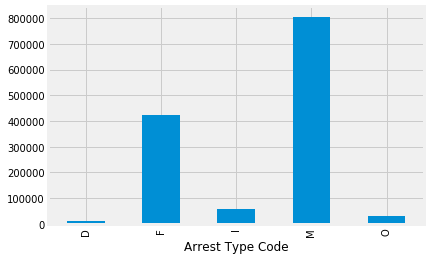

In [41]:
df.groupby('Arrest Type Code')['Arrest Type Code'].count().plot(kind = 'bar')

#### Descent Code

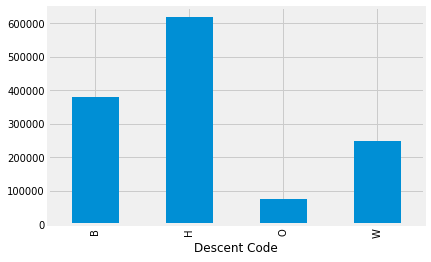

In [47]:
df.groupby('Descent Code')['Descent Code'].count().plot(kind = 'bar')

#### Hour

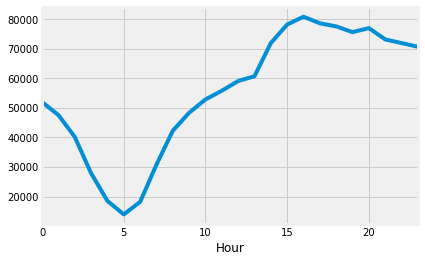

In [44]:
df.groupby('Hour')['Hour'].count().plot(kind = 'line')

#### Age

The graph below provides a histogram for the distribution of ages. There is a sharp rise in the number of arrests for teenagers through the mid-20s. Arrests steadily fall from the mid-twenties, plateau in the 40s and 50s and then decline. As previously noted, there are observations with an age of zero and observations with ages too young to be valid data. MAYBE ADD A BOXPLOT?

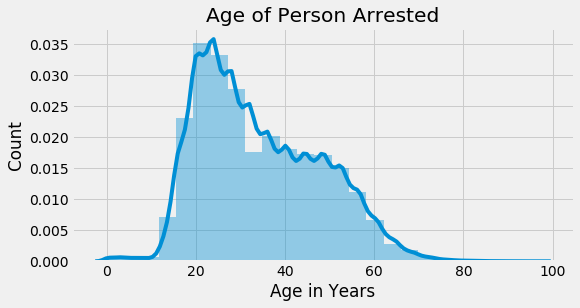

In [32]:
# set plot style
plt.style.use('fivethirtyeight')
plt.figure(figsize = (8, 4))

# distribution of age in years
sns.distplot(df['Age'], bins = 25);
plt.title('Age of Person Arrested'); plt.xlabel('Age in Years'); plt.ylabel('Count');

#### Reporting District

We expected there to be areas of Los Angeles with a higher number of arrest incidents. The map below uses a color-scale to highlight Reporting Districts with higher arrest counts. The cluster of lighter Reporting Districts represents Hollywood in the map below. We used this type of visualization to get a better sense of where the highest number of arrests are occurring, in the context of a map.

Text(0.5, 1, 'Arrests by Reporting District')

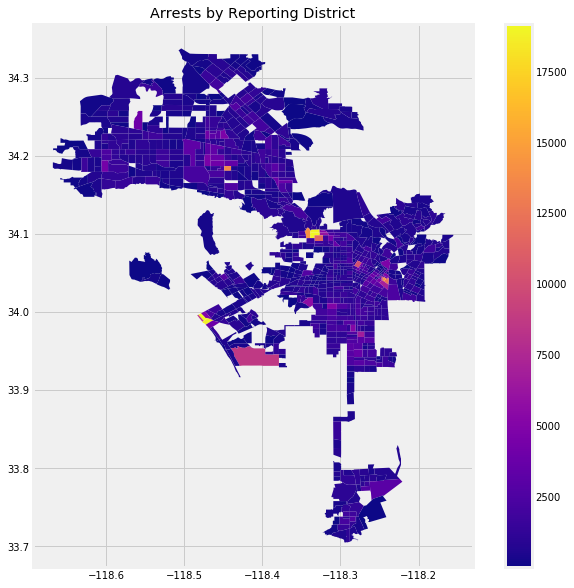

In [53]:
gdf = gpd.read_file('C:/Users/b007224/Documents/masters_in_data_science/machine_learning/project/LAPD_Reporting_Districts.shp')

#create counts to merge with polygon dataframe 

district_counts = df['Reporting District'].value_counts().reset_index().rename(columns={'index': 'Key'})
district_counts.columns = ['Key', 'District Counts']

male = df[df['Sex Code'] == 'M']
male_counts = male['Reporting District'].value_counts().reset_index().rename(columns={'index': 'key'})
male_counts.columns = ['Key','Male_Counts']

female = df[df['Sex Code'] == 'F']
female_counts = female['Reporting District'].value_counts().reset_index().rename(columns={'index': 'key'})
female_counts.columns = ['Key','Female_Counts']

arrestf = df[df['Arrest Type Code'] == 'F']
arrestf_counts = arrestf['Reporting District'].value_counts().reset_index().rename(columns={'index': 'key'})
arrestf_counts.columns = ['Key','Felony_Counts']

arrestm = df[df['Arrest Type Code'] == 'M']
arrestm_counts = arrestm['Reporting District'].value_counts().reset_index().rename(columns={'index': 'key'})
arrestm_counts.columns = ['Key','Misdemeanor_Counts']

arresti = df[df['Arrest Type Code'] == 'I']
arresti_counts = arresti['Reporting District'].value_counts().reset_index().rename(columns={'index': 'key'})
arresti_counts.columns = ['Key','Infraction_Counts']

arresto = df[df['Arrest Type Code'] == 'F']
arresto_counts = arresto['Reporting District'].value_counts().reset_index().rename(columns={'index': 'key'})
arresto_counts.columns = ['Key','Other_Counts']

year_counts = df.groupby(['Reporting District','arrest_year']).size().reset_index()
year_counts.columns = ['Key','Year','Year_Dist_Counts']
year_counts['Key']=year_counts['Key'].astype(int)

merged1 = district_counts.merge(male_counts, left_on='Key', right_on='Key')
merged2 = merged1.merge(female_counts,left_on='Key', right_on='Key')
merged3 = merged2.merge(arrestf_counts,left_on='Key', right_on='Key')
merged4 = merged3.merge(arrestm_counts,left_on='Key', right_on='Key')
merged5 = merged4.merge(arresti_counts,left_on='Key', right_on='Key')
merged6 = merged5.merge(arresto_counts,left_on='Key', right_on='Key')
merged6['Key']=merged2['Key'].astype(int)

#merge polygon dataframe with counts by reporting district
gdf1 = gdf.merge(merged6, left_on='REPDIST', right_on='Key')
gdf2 = gdf1.merge(year_counts, left_on='REPDIST',right_on='Key')

%matplotlib inline
gdf1.plot(column='District Counts', cmap='plasma', figsize=(10, 10),  legend=True)
plt.title('Arrests by Reporting District')

### Explore Joint Attributes
*(15 points)*  
*Explore relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.*  

##### Age by Sex Code

The KDE plot below shows the distributionn of Ages for Males compared with Females. While similar distributions are seen for males and females, a greater proportion of female arrests occur at young ages than males.

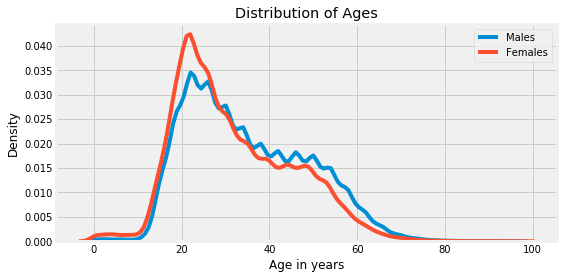

In [48]:
plt.figure(figsize = (8, 4))

# KDE Plot of males
sns.kdeplot(df.loc[df['Sex Code'] == 'M', 'Age'], label = 'Males')

# KDE plot of females                   
sns.kdeplot(df.loc[df['Sex Code'] == 'F', 'Age'], label = 'Females')

# Labels
plt.xlabel('Age in years'); plt.ylabel('Density'); plt.title('Distribution of Ages');

##### Age by Arrest Type Code

Plotting Age by `Arrest Type Code` highlights a strong correlation between the Dependent arrest type and younger individuals. There are records where a young individual is arrested wwith a different `Arrest Type Code`, but the majority of young individuals arrested with a Dependent `Arrest Type Code`. 

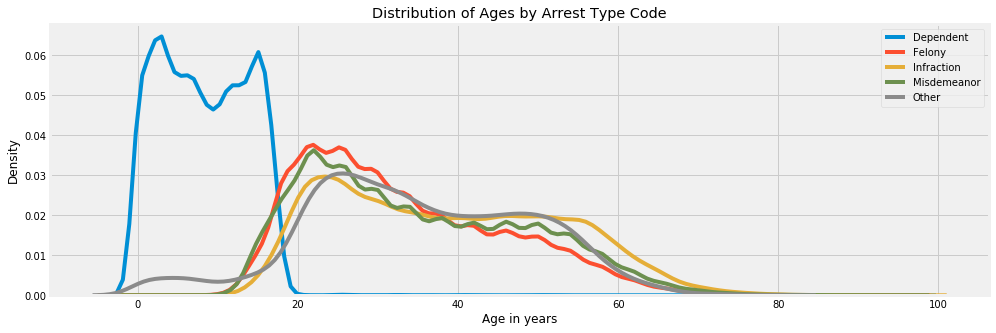

In [49]:
plt.figure(figsize = (15, 5))

# KDE Plot of Dependent Arrest Code
sns.kdeplot(df.loc[df['Arrest Type Code'] == 'D', 'Age'], label = 'Dependent')

# KDE plot of Felony Arrest Code                   
sns.kdeplot(df.loc[df['Arrest Type Code'] == 'F', 'Age'], label = 'Felony')

# KDE plot of Infraction Arrest Code                   
sns.kdeplot(df.loc[df['Arrest Type Code'] == 'I', 'Age'], label = 'Infraction')

# KDE plot of Misdemeanor Arrest Code                   
sns.kdeplot(df.loc[df['Arrest Type Code'] == 'M', 'Age'], label = 'Misdemeanor')

# KDE plot of Other Arrest Code                   
sns.kdeplot(df.loc[df['Arrest Type Code'] == 'O', 'Age'], label = 'Other')

# Labels
plt.xlabel('Age in years'); plt.ylabel('Density'); plt.title('Distribution of Ages by Arrest Type Code');

We will treat the observations where age is less than 16 as possible data entry errors. Due to this assumption and the close relationship between `Age` and the `Arrest Type Code` Dependent we will filter out observations with `Age` less than 16 or observations with `Arrest Type Code` of Dependent. We have choosen to not impute the values since we have such a large dataset.

In [51]:
# Drop the observations where Age is less than 16
df.drop(df[df['Age'] < 16].index, inplace = True) 
df.drop(df[df['Arrest Type Code'] == 'D'].index, inplace = True) 

print("The data set has {:,} rows and {:,} columns after filtering on Age and Arrest Type Code.".format(*df.shape))

The data set has 1,277,176 rows and 20 columns after filtering on Age and Arrest Type Code.


#### Descent Code
##### Kernel Density Estimate Plot of Age by Descent Code

In [ ]:
plt.figure(figsize = (15, 5))

# KDE Plots Age by Descent Code
sns.kdeplot(df.loc[df['Descent Code'] == 'B', 'Age'], label = 'Black')
sns.kdeplot(df.loc[df['Descent Code'] == 'H', 'Age'], label = 'Hispanic')
sns.kdeplot(df.loc[df['Descent Code'] == 'W', 'Age'], label = 'White')
sns.kdeplot(df.loc[df['Descent Code'] == 'I', 'Age'], label = 'American Indian/Alaskan Native')
sns.kdeplot(df.loc[df['Descent Code'] == 'O', 'Age'], label = 'Other')

# CN: Still working on these:
#Asian = ['A', 'C', 'D', 'G', 'F', 'J', 'K', 'L', 'V', 'Z']
#PacificIslander = ['G', 'S', 'P', 'U']

#sns.kdeplot(df[df['Descent Code'].isin(Asian), 'Age'], label = 'Asian')
#sns.kdeplot(df[df['Descent Code'].isin(PacificIslander), 'Age'], label = 'Pacific Islander')


# Labels
plt.xlabel('Age in years'); plt.ylabel('Density'); plt.title('Distribution of Ages by Descent Code');

In [ ]:
plt.figure(figsize = (15, 5))

# KDE Plots Age by Arrest Year
sns.kdeplot(df.loc[df['arrest_year'] == 2010, 'Age'], label = '2010')
sns.kdeplot(df.loc[df['arrest_year'] == 2011, 'Age'], label = '2011')
sns.kdeplot(df.loc[df['arrest_year'] == 2012, 'Age'], label = '2012')
sns.kdeplot(df.loc[df['arrest_year'] == 2013, 'Age'], label = '2013')
sns.kdeplot(df.loc[df['arrest_year'] == 2014, 'Age'], label = '2014')
sns.kdeplot(df.loc[df['arrest_year'] == 2015, 'Age'], label = '2015')
sns.kdeplot(df.loc[df['arrest_year'] == 2016, 'Age'], label = '2016')
sns.kdeplot(df.loc[df['arrest_year'] == 2017, 'Age'], label = '2017')
sns.kdeplot(df.loc[df['arrest_year'] == 2018, 'Age'], label = '2018')
sns.kdeplot(df.loc[df['arrest_year'] == 2019, 'Age'], label = '2019')

# Labels
plt.xlabel('Age in years'); plt.ylabel('Density'); plt.title('Distribution of Ages by Arrest Year');

In [ ]:
# Sex plot
arrests_by_code = df["Sex Code"].value_counts()
arrests_by_code.sort_values().plot(kind='barh')
plt.title('Arrests by Sex')
plt.ylabel('Sex')
plt.xlabel('Arrests')

In [ ]:
# cross tabulate example from http://nbviewer.ipython.org/gist/fonnesbeck/5850463# 
%matplotlib inline
counts = pd.crosstab([df['Arrest Type Code']], df['Sex Code'])
counts.plot(kind='bar', stacked=True)

# divide the counts to get rates
rate = counts.div(counts.sum(1).astype(float),axis=0)
rate.plot(kind='barh', stacked=True)

In [ ]:
# Descent code plot
arrests_by_code = df["Descent Code"].value_counts()
arrests_by_code.sort_values().plot(kind='barh')
plt.title('Arrests by Descent Code')
plt.ylabel('Descent Code')
plt.xlabel('Arrests')

In [ ]:
# cross tabulate example from http://nbviewer.ipython.org/gist/fonnesbeck/5850463# 
%matplotlib inline
counts = pd.crosstab(df['Descent Code'], df['Sex Code'])
counts.plot(kind='bar', stacked=True)

# divide the counts to get rates
rate = counts.div(counts.sum(1).astype(float),axis=0)
rate.plot(kind='barh', stacked=True)

In [ ]:
%matplotlib inline
descent = ['B','H','O','W']
descent_code = df[df['Descent Code'].isin(descent)]
descent_code.head()
# cross tabulate example from http://nbviewer.ipython.org/gist/fonnesbeck/5850463# 
counts = pd.crosstab([descent_code['Descent Code'],descent_code['Arrest Type Code']], descent_code['Sex Code'])
counts.plot(kind='bar', stacked=True)

# divide the counts to get rates
rate = counts.div(counts.sum(1).astype(float),axis=0)
rate.plot(kind='barh', stacked=True)

##### Arrests by Gender and Day of Week

In [ ]:
# define colors
coral = '#f88c8c'
lightgreen = '#99ee98'

In [ ]:
pd.crosstab(index=df['arrest_day_of_week'], columns=df['Sex Code']).style.format("{:,.0f}").highlight_max(color=lightgreen).highlight_min(color=coral)

In [ ]:
sns.set(rc={'figure.figsize':(20,35)})

# Violin Plot
sns.catplot(x = "Age",
           y = "arrest_day_of_week",
           hue = "Sex Code",
           kind = "violin",
           data = df,
           height = 8);

# Labels
plt.xlabel('Age in years'); plt.ylabel('Day of Week'); plt.title('Distribution of Ages by Gender and Day of Week');

In [ ]:
# cross tab of arrests by Gender, Arrest Type Code, and Day of Week
pd.crosstab(index=df['arrest_day_of_week'], 
            columns=[df['Sex Code'], 
                     df['Arrest Type Code']], 
            colnames=['Sex Code','Arrest Type Code']).style.format("{:,.0f}").highlight_max(color = lightgreen).highlight_min(color = coral)

In [ ]:
# Violin plot
sns.catplot(x = "Age",
           y = "Arrest Type Code",
           hue = "Sex Code",
           kind = "violin",
           data = df,
           height = 8);

# Labels
plt.xlabel('Age in years'); plt.ylabel('Arrest Type Code'); plt.title('Distribution of Ages by Gender and Arrest Type Code');

In [ ]:
#CN: Something is broken with this one. Need to keep working on it.
#Violin Plot
#sns.catplot(x = "Age",
#           y = df["Descent Code"],
#           hue = "Sex Code",
#           kind = "violin",
#           data = df,
#           height = 8);

# Labels
#plt.xlabel('Age in years'); plt.ylabel('Descent Code'); plt.title('Distribution of Ages by Gender and Descent Code');

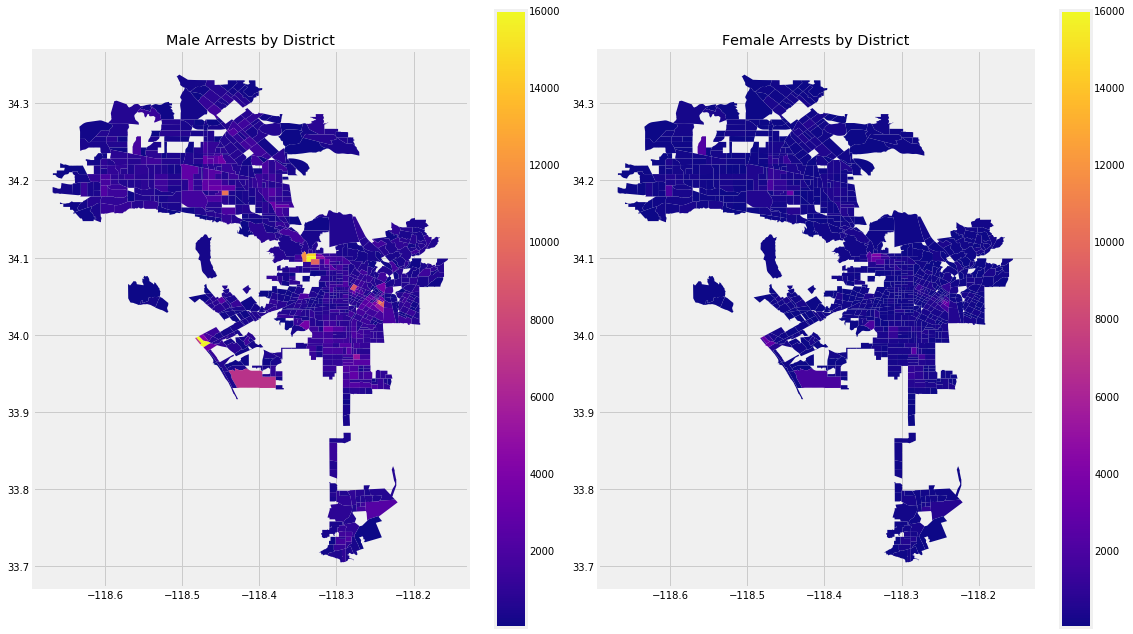

In [84]:
%matplotlib inline
fig = plt.figure(figsize=(16,18))
ax = plt.subplot(2,2,1)
gdf1.plot(column='Male_Counts', ax=ax, cmap='plasma', legend=True, vmax = 16000)
ax.set_title('Male Arrests by District')
ax.set_aspect('equal')

ax = plt.subplot(2,2,2)
gdf1.plot(column='Female_Counts', ax=ax, cmap='plasma', legend=True, vmax = 16000)
ax.set_title('Female Arrests by District')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

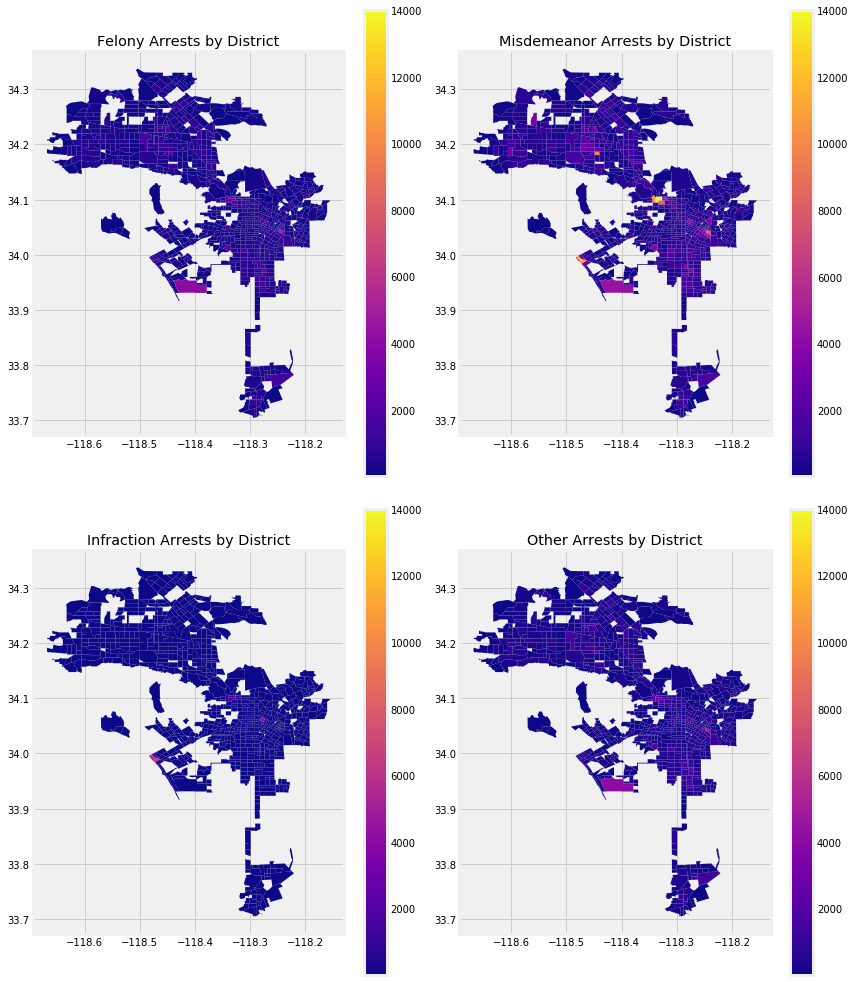

In [80]:
%matplotlib inline
fig = plt.figure(figsize=(12,14))
ax = plt.subplot(2,2,1)
gdf1.plot(column='Felony_Counts', ax=ax, cmap='plasma', legend=True, vmax = 14000)
ax.set_title('Felony Arrests by District')
ax.set_aspect('equal')

ax = plt.subplot(2,2,2)
gdf1.plot(column='Misdemeanor_Counts', ax=ax, cmap='plasma', legend=True, vmax = 14000)
ax.set_title('Misdemeanor Arrests by District')
ax.set_aspect('equal')

ax = plt.subplot(2,2,3)
gdf1.plot(column='Infraction_Counts', ax=ax, cmap='plasma', legend=True, vmax = 14000)
ax.set_title('Infraction Arrests by District')
ax.set_aspect('equal')

ax = plt.subplot(2,2,4)
gdf1.plot(column='Other_Counts', ax=ax, cmap='plasma', legend=True, vmax = 14000)
ax.set_title('Other Arrests by District')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

In [ ]:
#https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
#https://github.com/CrazyDaffodils/Interactive-Choropleth-Map-Using-Python

#Read data to json
merged_json = json.loads(gdf2.to_json())

#Convert to str like object
json_data = json.dumps(merged_json)

In [ ]:
#Define function that returns json_data for year selected by user.
    
def json_data(selectedYear):
    yr = selectedYear
    df_yr = gdf2[gdf2['Year'] == yr]
    #merged = gdf.merge(df_yr, left_on = 'country_code', right_on = 'code', how = 'left')
    #merged.fillna('No data', inplace = True)
    merged_json = json.loads(df_yr.to_json())
    json_data = json.dumps(merged_json)
    return json_data

#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_data(2010))

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][9]

#Reverse color order so that dark blue is highest obesity.
#palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors. Input nan_color.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 2500)

#Define custom tick labels for color bar.
#tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}

#Add hover tool
hover = HoverTool(tooltips = [ ('Reporting District','@REPDIST'),('Arrests', '@Year_Dist_Counts')])


#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
                     border_line_color=None,location = (0,0), orientation = 'horizontal')


#Create figure object.
p = figure(title = 'Los Angeles Arrests by Reporting District', plot_height = 850 , plot_width = 600, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Year_Dist_Counts', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)


p.add_layout(color_bar, 'below')

# Define the callback function: update_plot
def update_plot(attr, old, new):
    yr = slider.value
    new_data = json_data(yr)
    geosource.geojson = new_data
    p.title.text = 'Arrest Counts' %yr
    
# Make a slider object: slider 
slider = Slider(title = 'Year',start = 2010, end = 2019, step = 1, value = 2010)
slider.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)

#Display plot inline in Jupyter notebook
output_notebook()

#Display plot
show(layout)

### Explore Attributes and Class
*(10 points)*  
*Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).*

### New Features
*(5 points)*  
*Are there other features that could be added to the data or created from
existing features? Which ones?*

## Exceptional Work
*(10 points)*  
• *You have free reign to provide additional analyses.  
• One idea: implement dimensionality reduction, then visualize and interpret the results.*

Distribution of ethnicities from the arrest data compared to Los Angeles 2010 Census findings. The [U.S. Census Bureau](https://www.census.gov/quickfacts/fact/note/US/RHI425218) counts Hispanic origin separate from race, as the category may overlap with other listed demographics. Representation of each ethnicity appears to match with percent distribution national arrest rates from the [FBI](https://ucr.fbi.gov/crime-in-the-u.s/2010/crime-in-the-u.s.-2010/tables/table-43/10tbl43a.xls)

Note: Federal level population data is not as complete as source data; many ethnicies are not listed

**Table 2: Demographic Breakdown of Arrests from 2010-Present in Los Angeles County**

|Descent Code|Ethnicity|Total Arrests|Percentage of Arrests|2010 Census Percentage of Population|2010 FBI Percentage of Arrests|
|:---:|:---:|:---:|:---:|:---:|:---:|
|A|Other Asian|5362|0.40%|1.2%|
|B|Black|380922|28.75%|8.7%|28%|
|C|Chinese|836|0.06%|
|D|Cambodian|2|0.00%
|F|Filipino|933|0.07%
|G|Guamanian|53|0.00%
|H|Hispanic/Latin/Mexican|618150|46.65%|47.5%
|I|American Indian/Alaskan Native|284|0.02%|0.5%|1.4%
|J|Japanese|168|0.01%
|K|Korean|1114|0.08%
|L|Laotian|6|0.00%
|O|Other|68067|5.14%
|P|Pacific Islander|179|0.01%
|S|Samoan|11|0.00%
|U|Hawaiian|7|0.00%
|V|Vietnamese|18|0.00%
|W|White|248742|18.77%|52.4%|69.4%
|X|Unknown|112|0.01%
|Z|Asian Indian|7|0.00%

# From [Wikipedia](https://en.wikipedia.org/wiki/Demographics_of_Los_Angeles_County)   

The demographics of Los Angeles County include a diverse people by race, ethnicity, and nationality. The 2010 United States Census reported that Los Angeles County had a population of 9,818,605. The racial makeup of Los Angeles County was 4,936,599 (50.3%) White, 856,874 (8.7%) African American, 72,828 (0.7%) Native American, 1,346,865 (13.7%) Asian (4.0% Chinese, 3.3% Filipino, 2.2% Korean, 1.0% Japanese, 0.9% Vietnamese, 0.8% Indian, 0.3% Cambodian, 0.3% Thai, 0.1% Pakistani), 26,094 (0.3%) Pacific Islander (0.1% Samoan), 2,140,632 (21.8%) from other races, and 438,713 (4.5%) from two or more races.

Total 2010 Los Angeles County Population: 10,116,705